In [30]:
from pathlib import Path
from itertools import product
import pandas as pd
import numpy as np
import datetime
import plotly.graph_objects as go
import copy
import plotly.express as px

from phd_visualizations import save_figure
from solarmed_optimization.utils import condition_result_dataframe

base_path = Path("/workspaces/SolarMED")
data_path = base_path / "optimization/data"
# results_path = base_path / "optimization/results/20180921_20180922/results_nNLP_op_plan_eval_at_20250522T1723_dev.h5"
results_paths = [
    Path("/workspaces/SolarMED/optimization/results/20180921_20180928/nNLP_op_plan_only/results_eval_at_20251104T1546_final.h5"),
    Path("/workspaces/SolarMED/optimization/results/20180921_20180928/NLP_op_optim_only/results_eval_at_20251101T1515_final.h5"),
    Path("/workspaces/SolarMED/optimization/results/20180921_20180928/heuristic/results_eval_at_20251031T1700_dev.h5")
    
]
output_path = results_paths[0].parent.parent
prefix_name = "solarmed_optim"
alt_labels = ["nNLP", "NLP", "Heuristic"] 

pattern_shapes = ["", "/", "x", ".", "\\", "x", "-", "|", "+"]
plotly_config = {
    "toImageButtonOptions": {
        "format": "png",            # png, svg, jpeg, webp
        # "filename": "my_custom_name",
        # "height": 800,
        # "width": 1200,
        "scale": 3                  # multiplies resolution (VERY important)
    }
}


In [2]:
# Simulation results
sim_dfs = [pd.read_hdf(results_path, key="sim_df") for results_path in results_paths]
# display(sim_df)


In [3]:
def keep_one_per_day(dt_index, criteria: str = "first"):
    dt_index = pd.to_datetime(dt_index)
    # Convert to DataFrame to use groupby
    df = pd.DataFrame({'dt': dt_index})
    # Keep only the first timestamp per day
    if criteria == "first":
        first_per_day = df.groupby(df['dt'].dt.date)['dt'].first()
    elif criteria == "last":
        first_per_day = df.groupby(df['dt'].dt.date)['dt'].last()
    else:
        raise ValueError("Criteria must be 'first' or 'last'")
    return pd.DatetimeIndex(first_per_day)

sfts_startup_dts_list = []
med_startup_dts_list = []
sfts_shutdown_dts_list = []
med_shutdown_dts_list = []

for sim_df in sim_dfs:
    sfts_startup_dts = sim_df[(sim_df["sf_ts_state"].diff() == 1) & (sim_df["sf_ts_state"] == 1)].index
    med_startup_dts = sim_df[(sim_df["med_state"].diff() == 1) & (sim_df["med_state"] == 1)].index
    
    sfts_shutdown_dts = sim_df[(((sim_df["sf_ts_state"].diff() == -1) | (sim_df["sf_ts_state"].diff() == -2))) & (sim_df["sf_ts_state"] == 0)].index
    med_shutdown_dts = sim_df[(sim_df["med_state"].diff() == -4) & (sim_df["med_state"] == 0)].index
    
    sfts_startup_dts_list.append(keep_one_per_day(sfts_startup_dts))
    med_startup_dts_list.append(keep_one_per_day(med_startup_dts))
    sfts_shutdown_dts_list.append(keep_one_per_day(sfts_shutdown_dts, criteria="last"))
    med_shutdown_dts_list.append(keep_one_per_day(med_shutdown_dts, criteria="last"))


<Axes: >

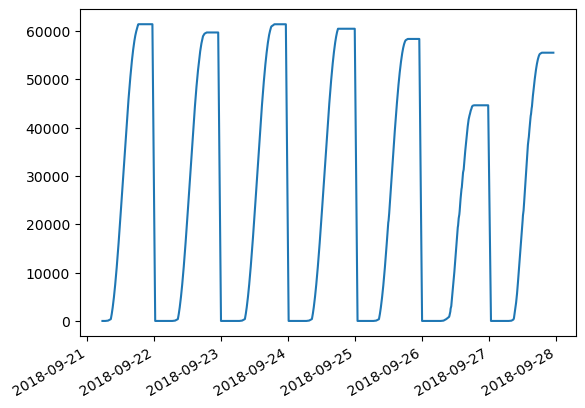

In [12]:
sim_dfs_ = copy.deepcopy(sim_dfs)
sim_dfs_ = [condition_result_dataframe(df) for df in sim_dfs_]
sim_dfs_[0]["daily_cumulative_I"].plot()


<Axes: >

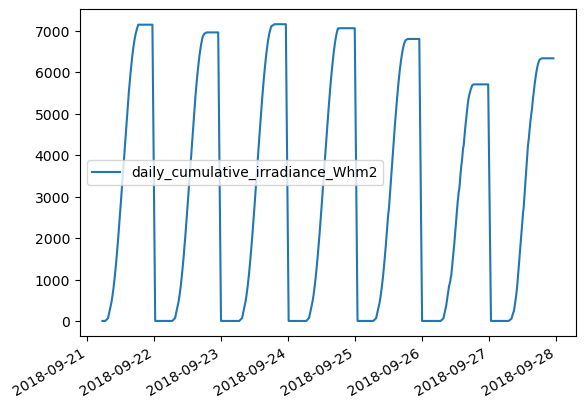

In [26]:
df = sim_dfs_[0][["I"]].copy()

# 1) Compute time difference between samples (in seconds)
df["dt_s"] = df.index.to_series().diff().dt.total_seconds()

# Replace the first NaN with zero (or you may drop it instead)
df["dt_s"] = df["dt_s"].fillna(0)

# 2) Compute energy per area for each interval (J/m²)
df["E_Jm2"] = df["I"] * df["dt_s"]

# 3) Daily cumulative irradiance (J/m²)
df["daily_cumulative_irradiance_Jm2"] = (
    df.groupby(df.index.date)["E_Jm2"].cumsum()
)

# 4) Optional: convert to Wh/m²
df["daily_cumulative_irradiance_Whm2"] = (
    df["daily_cumulative_irradiance_Jm2"] / 3600
)

df[["daily_cumulative_irradiance_Whm2"]].plot()


In [4]:
last_val_vars = ["cumulative_net_profit", "daily_cumulative_net_profit", "Tts_h_t_last"]
first_val_vars = ["Tts_h_t_first"]

sim_dfs_ = copy.deepcopy(sim_dfs)
sim_dfs_ = [condition_result_dataframe(df) for df in sim_dfs_]

daily_sim_dfs = []
for sim_df in sim_dfs_:
    
    sim_df["Tts_h_t_first"] = sim_df["Tts_h_t"]
    sim_df["Tts_h_t_last"] = sim_df["Tts_h_t"]
    sim_df["deltaTsf"] = sim_df["Tsf_out"] - sim_df["Tsf_in"]
    
    # Ensure datetime index
    sim_df.index = pd.to_datetime(sim_df.index)

    # Create a copy to hold filtered data
    sim_df_filtered = sim_df.copy()

    # Replace zeros with NaN for all variables except the "last value" ones
    vars_to_filter = [col for col in sim_df.columns if col not in (last_val_vars + first_val_vars)]
    sim_df_filtered[vars_to_filter] = sim_df_filtered[vars_to_filter].replace(0, np.nan)

    # Resample using mean, skipping NaN automatically
    daily_mean = sim_df_filtered[vars_to_filter].resample("D").mean()

    # Add the “last” values per day for cumulative variables
    for var_id in last_val_vars:
        if var_id in sim_df.columns:
            daily_mean[var_id] = sim_df[var_id].resample("D").last()
            
    # Add the “first” values per day for first value variables
    for var_id in first_val_vars:
        if var_id in sim_df.columns:
            daily_mean[var_id] = sim_df[var_id].resample("D").first()
            
    daily_mean["deltaTmed_s"] = daily_mean["Tmed_s_in"] - daily_mean["Tmed_s_out"]

    daily_sim_dfs.append(daily_mean)

    # Special case, irradiance
    # Time diffs in seconds
    dt = sim_df.index.to_series().diff().dt.total_seconds().fillna(0)

    # Interval energy in J/m² (Series)
    E = sim_df["I"] * dt

    # Daily cumulative irradiance (J/m²)
    daily_sim_dfs[-1]["daily_cumulative_I_Jm2"] = (
        E.groupby(sim_df.index.date).cumsum().resample("D").last()
    )
    daily_sim_dfs[-1]["daily_cumulative_I_Whm2"] = (
        daily_sim_dfs[-1]["daily_cumulative_I_Jm2"] / 3600
    )
    daily_sim_dfs[-1]["daily_cumulative_I_kWhm2"] = (
        daily_sim_dfs[-1]["daily_cumulative_I_Whm2"] / 1000
    )

    

for alt_label, daily_df in zip(alt_labels, daily_sim_dfs):
    print(f"Final cumulative benefit for {alt_label}: {daily_df['cumulative_net_profit'].iloc[-1]:.2f} (u.m.)")
    print(f"Average deltaTmed_s for {alt_label}: {daily_df['deltaTmed_s'].mean():.2f} °C")

vars_to_show = last_val_vars + ["I", "daily_cumulative_I_kWhm2", "Tmed_s_in", "Tts_h_t_first", "Tts_h_t_last", "deltaTsf", "deltaTmed_s"]
[display(df[vars_to_show]) for df in daily_sim_dfs]


Final cumulative benefit for nNLP: 508.99 (u.m.)
Average deltaTmed_s for nNLP: 3.32 °C
Final cumulative benefit for NLP: 403.97 (u.m.)
Average deltaTmed_s for NLP: 3.51 °C
Final cumulative benefit for Heuristic: 346.86 (u.m.)
Average deltaTmed_s for Heuristic: 2.34 °C


,cumulative_net_profit,daily_cumulative_net_profit,Tts_h_t_last,I,daily_cumulative_I_kWhm2,Tmed_s_in,Tts_h_t_first,Tts_h_t_last,deltaTsf,deltaTmed_s
2018-09-21 00:00:00+00:00,75.335178,75.335178,63.557634,674.436176,7.151136,69.100359,90.000000,63.557634,37.943975,3.579636
2018-09-22 00:00:00+00:00,146.042959,70.707781,64.238651,621.518521,6.964542,67.605569,63.518704,64.238651,38.774785,3.183979
2018-09-23 00:00:00+00:00,219.537765,73.494806,64.489253,632.624586,7.162428,68.222155,64.198746,64.489253,35.308184,3.294502
2018-09-24 00:00:00+00:00,288.525409,68.987643,75.938232,694.690607,7.065805,67.905068,64.449805,75.938232,37.247655,3.355945
2018-09-25 00:00:00+00:00,369.635312,81.109903,63.508835,607.580769,6.806849,69.481381,75.886587,63.508835,26.580326,3.179105
2018-09-26 00:00:00+00:00,429.167264,59.531952,57.631472,530.995859,5.710184,66.401888,63.469874,57.631472,29.816572,3.265886
2018-09-27 00:00:00+00:00,508.993224,79.825960,60.054218,577.939967,6.339351,67.504977,57.598416,60.054218,26.638990,3.403644


,cumulative_net_profit,daily_cumulative_net_profit,Tts_h_t_last,I,daily_cumulative_I_kWhm2,Tmed_s_in,Tts_h_t_first,Tts_h_t_last,deltaTsf,deltaTmed_s
2018-09-21 00:00:00+00:00,55.566788,55.566788,79.352860,740.468723,7.100182,68.382775,90.000000,79.352860,43.311456,2.925189
2018-09-22 00:00:00+00:00,111.018883,55.452095,74.957593,734.929751,6.959529,71.023772,79.297408,74.957593,38.061651,3.500463
2018-09-23 00:00:00+00:00,157.490634,46.471751,70.509308,740.076815,7.124681,70.916004,74.906230,70.509308,37.075264,3.496818
2018-09-24 00:00:00+00:00,221.440233,63.949599,69.862192,740.662879,7.091320,70.505489,70.463893,69.862192,40.491957,3.850846
2018-09-25 00:00:00+00:00,282.723103,61.282870,78.758556,715.996417,6.776731,71.280291,69.816971,78.758556,33.473127,3.696039
2018-09-26 00:00:00+00:00,340.572490,57.849387,69.931307,576.600696,5.560357,70.216434,78.703423,69.931307,28.279389,3.680684
2018-09-27 00:00:00+00:00,403.968797,63.396307,66.881675,683.596967,6.456809,68.826258,69.885524,66.881675,35.566691,3.444542


,cumulative_net_profit,daily_cumulative_net_profit,Tts_h_t_last,I,daily_cumulative_I_kWhm2,Tmed_s_in,Tts_h_t_first,Tts_h_t_last,deltaTsf,deltaTmed_s
2018-09-21 00:00:00+00:00,52.422067,52.422067,64.569306,567.379060,6.934633,70.621321,89.992185,64.569306,24.152083,2.413265
2018-09-22 00:00:00+00:00,103.152129,50.730062,64.396622,551.971338,6.807646,72.488160,64.564830,64.396622,25.089729,2.404752
2018-09-23 00:00:00+00:00,153.333272,50.181143,64.610827,571.094196,6.980040,72.545373,64.392102,64.610827,25.586048,2.428958
2018-09-24 00:00:00+00:00,207.766346,54.433074,64.300061,568.497422,6.948302,72.510274,64.606423,64.300061,25.794372,2.412049
2018-09-25 00:00:00+00:00,262.166271,54.399925,64.137317,538.359586,6.639768,72.424347,64.295609,64.137317,24.507623,2.380487
2018-09-26 00:00:00+00:00,298.731623,36.565352,64.401427,444.001806,5.426689,71.690584,64.132821,64.401427,22.252962,2.042124
2018-09-27 00:00:00+00:00,346.855059,48.123436,64.390604,514.511749,6.288477,72.196194,64.396903,64.390604,23.302389,2.273603
2018-09-28 00:00:00+00:00,346.855059,0.000000,64.385818,NaN,0.000000,NaN,64.385818,64.385818,NaN,NaN


[None, None, None]

In [23]:
daily_sim_dfs[0]


,penalty,Jsf_ts,current_sample,wmed_f,Tamb,I,Tmed_c_in,qts_src_sp,qts_src,qts_dis,...,cost_e,cost_w,daily_cumulative_I,deltaTsf,cumulative_net_profit,daily_cumulative_net_profit,Tts_h_t_last,Tts_h_t_first,deltaTmed_s,daily_cumulative_I_Jm2
2018-09-21 00:00:00+00:00,NaN,1.367199,47.778947,35.0,31.575754,674.436176,22.292336,10.616873,10.616873,27.841078,...,3.0,3.0,34241.594199,37.943975,75.335178,75.335178,63.557634,90.000000,3.579636,NaN
2018-09-22 00:00:00+00:00,NaN,1.120803,134.694444,35.0,31.306217,621.518521,22.755548,9.578594,9.578594,23.725718,...,3.0,3.0,35080.967999,38.774785,146.042959,70.707781,64.238651,63.518704,3.183979,NaN
2018-09-23 00:00:00+00:00,NaN,0.879188,229.690909,35.0,32.126325,632.624586,23.075180,8.215710,8.215710,15.760380,...,3.0,3.0,36083.276709,35.308184,219.537765,73.494806,64.489253,64.198746,3.294502,0.0
2018-09-24 00:00:00+00:00,NaN,1.372408,320.580000,35.0,32.781882,694.690607,22.455063,10.608950,10.608950,19.462890,...,3.0,3.0,33035.744235,37.247655,288.525409,68.987643,75.938232,64.449805,3.355945,NaN
2018-09-25 00:00:00+00:00,NaN,0.756976,408.196262,35.0,29.241860,607.580769,21.643750,7.390870,7.390870,16.068992,...,3.0,3.0,33992.231211,26.580326,369.635312,81.109903,63.508835,75.886587,3.179105,NaN
2018-09-26 00:00:00+00:00,NaN,0.754675,495.247423,35.0,28.402791,530.995859,21.509262,7.765174,7.765174,41.696389,...,3.0,3.0,26399.171389,29.816572,429.167264,59.531952,57.631472,63.469874,3.265886,0.0
2018-09-27 00:00:00+00:00,NaN,1.214632,582.196262,35.0,27.296178,577.939967,20.987565,10.041379,10.041379,20.126583,...,3.0,3.0,30881.423107,26.638990,508.993224,79.825960,60.054218,57.598416,3.403644,NaN


## Visualize startup/shutdown 
Times distribution and comparison between alternatives

In [15]:
# print(f"{sfts_startup_dts_list=}")
# print(f"{med_startup_dts_list=}")
# print(f"{sfts_shutdown_dts_list=}")
# print(f"{med_shutdown_dts_list=}")


In [51]:
sim_df[ (((sim_df["sf_ts_state"].diff() == -1) | (sim_df["sf_ts_state"].diff() == -2))) & (sim_df["sf_ts_state"] == 0) ]


,penalty,Jsf_ts,current_sample,wmed_f,Tamb,I,Tmed_c_in,qts_src_sp,qts_src,qts_dis,...,sf_ts_state,current_state,Tts_h_t,Tts_h_m,Tts_h_b,Tts_c_t,Tts_c_m,Tts_c_b,cost_e,cost_w
2018-09-21 18:13:20+00:00,0.0,0.0,120,35.0,31.480900,36.794429,22.509493,0.0,0.0,0.000000,...,0,4,64.786681,64.645142,63.834632,64.977275,64.309215,63.666549,3,3
2018-09-22 17:46:40+00:00,0.0,0.0,332,35.0,32.065775,100.746514,23.050730,0.0,0.0,19.082288,...,0,5,76.654717,74.799176,71.505490,75.415209,72.463047,70.869952,3,3
2018-09-23 18:00:00+00:00,0.0,0.0,550,35.0,32.251000,172.456067,23.318281,0.0,0.0,19.685576,...,0,5,76.142276,73.801775,71.114412,74.388788,72.043101,70.790042,3,3
2018-09-24 18:00:00+00:00,0.0,0.0,766,35.0,33.455375,178.042348,22.134027,0.0,0.0,18.984945,...,0,5,76.550691,74.458981,71.361552,75.000372,72.317811,70.860628,3,3
2018-09-25 17:40:00+00:00,0.0,0.0,979,35.0,29.283850,214.827628,21.707733,0.0,0.0,17.021787,...,0,5,77.457474,75.273114,71.577099,75.713801,72.604484,70.879283,3,3
2018-09-26 10:20:00+00:00,0.0,0.0,1129,35.0,28.074125,241.337778,21.502218,0.0,0.0,0.000000,...,0,0,63.720973,62.789463,56.426226,63.041219,63.504472,51.982154,3,3
2018-09-26 17:40:00+00:00,0.0,0.0,1195,35.0,27.354275,194.117295,21.470623,0.0,0.0,43.200000,...,0,5,66.961217,66.177292,65.138744,66.904606,65.983223,64.739175,3,3
2018-09-27 18:00:00+00:00,0.0,0.0,1414,35.0,26.566925,145.320675,21.036234,0.0,0.0,43.200000,...,0,5,66.986427,66.060540,65.186953,66.909337,66.062453,64.840418,3,3


In [8]:
categories = [f"Day {dt.day+1}" for dt in sfts_startup_dts_list[0]]

# Offsets to separate alternatives visually — compute adaptively for n alternatives
n_alts = len(alt_labels)
# Spread offsets evenly within one plot row (total vertical span reserved per category)
max_offset_span = 0.5  # maximum vertical span used by all alternatives
if n_alts > 1:
    alt_offsets = [i * (max_offset_span / (n_alts - 1)) for i in range(n_alts)]
else:
    alt_offsets = [0]


# Initialize figure
fig = go.Figure()

# Bar height
bar_height = 0.1

for alt_idx, alt in enumerate(alt_labels):
    # Apply vertical offset for this alternative
    y_base = [i + alt_offsets[alt_idx] for i in range(len(categories))]
    pat = pattern_shapes[alt_idx % len(pattern_shapes)] if len(pattern_shapes) > 0 else ""
    
    mean_sfts_diffs = (sfts_shutdown_dts_list[alt_idx] - sfts_startup_dts_list[alt_idx]).total_seconds()/3600
    mean_med_diffs = (med_shutdown_dts_list[alt_idx] - med_startup_dts_list[alt_idx]).total_seconds()/3600
    
    bar_text_sfts = [f"{duration:.1f}" for duration in mean_sfts_diffs.tolist()]
    bar_text_med = [f"{duration:.1f}" for duration in mean_med_diffs.tolist()]
    
    # sfts bars
    fig.add_trace(go.Bar(
        x=(sfts_shutdown_dts_list[alt_idx] - sfts_startup_dts_list[alt_idx]).total_seconds()/3600,  # duration in hours
        y=y_base,
        base=[d.hour + d.minute/60 + d.second/3600 for d in sfts_startup_dts_list[alt_idx]],
        orientation='h',
        name=f'sfts ({alt}) - {mean_sfts_diffs.to_numpy().mean():.1f}h',
        width=bar_height,
        marker_color='#FECB52',
        hovertext=categories,
        hoverinfo='text+x',
        marker_pattern_shape=pat,
        marker_pattern_fgcolor="white",
        text=bar_text_sfts,
        textposition='outside',
        outsidetextfont=dict(size=10)
    ))

    # med bars
    fig.add_trace(go.Bar(
        x=(med_shutdown_dts_list[alt_idx] - med_startup_dts_list[alt_idx]).total_seconds()/3600,
        y=[y + bar_height for y in y_base],  # stack slightly above sfts
        base=[d.hour + d.minute/60 + d.second/3600 for d in med_startup_dts_list[alt_idx]],
        orientation='h',
        name=f'med ({alt}) - {mean_med_diffs.to_numpy().mean():.1f}h',
        width=bar_height,
        marker_color='#9573a6',
        hovertext=categories,
        hoverinfo='text+x',
        marker_pattern_shape=pat,
        marker_pattern_fgcolor="white",
        text=bar_text_med,
        textposition='outside',
        # textfont=dict(size=12),
        outsidetextfont=dict(size=10)
    ))

# Customize y-axis
fig.update_yaxes(
    tickvals=[i + 0.25 for i in range(len(categories))],  # center labels
    ticktext=categories,
    autorange='reversed'
)

# Customize x-axis
fig.update_xaxes(title='Time of Day (hours)', tickformat='%H:%M', range=[None, 21.5])

# Layout
fig.update_layout(
    barmode='overlay',  # overlay bars with offsets
    # title='Startup/Shutdown comparison for alternatives',
    # xaxis_range=[0, 24]  # full day range
    height=300 + len(categories)*30, # 600 + len(categories)*30,
    xaxis=dict(nticks=12),
    width=400, # 400,
    legend=dict(orientation='h', yanchor='bottom', y=1.01, xanchor='center', x=0.5, ),
    title_y=0.99,
    template="plotly_white",
    uniformtext_minsize=10,
    uniformtext_mode='show',
    margin=dict(t=5, b=5, l=5, r=5)
)

fig.show()


In [9]:
save_figure(
    fig,
    output_path / f"{prefix_name}_startup_shutdown_comparison2",
    figure_path=output_path,
    formats=["png", "html"],
)


2025-11-19 10:42:13.339 | INFO     | phd_visualizations:save_figure:41 - Figure saved in /workspaces/SolarMED/optimization/results/20180921_20180928/solarmed_optim_startup_shutdown_comparison2.png
2025-11-19 10:42:13.397 | INFO     | phd_visualizations:save_figure:41 - Figure saved in /workspaces/SolarMED/optimization/results/20180921_20180928/solarmed_optim_startup_shutdown_comparison2.html


## Visualize and compare key variables

In [32]:
def paired_variable_plot(
    df: pd.DataFrame | list[pd.DataFrame], 
    var1_col: str, 
    var2_col: str,
    x_col: str | None = None, 
    var1_label: str | None = None,
    var2_label: str | None = None,
    bg_var_col: str | None = None,
    bg_var_label: str | None = None,
    alt_labels: list[str] | None = None, 
    marker_symbols: list[str] | None = None, 
    spacing: float = 0.3,
    var_unit: str = "",
    show_bg_label: bool = True,
    **kwargs
) -> go.Figure:
    """Create a scatter plot with arrows connecting var1 to var2 for each x value.
    X-axis is treated as categorical with spacing between alternatives.
    
    Parameters:
    - df: pd.DataFrame or list[pd.DataFrame] - data source(s)
    - x_col: str - column name for x-axis, if None index is used (treated as categorical)
    - var1_col: str - column name for first variable (starting point of arrow)
    - var2_col: str - column name for second variable (ending point of arrow)
    - alt_labels: list[str] | None - optional labels if df is a list
    - pattern_shapes: list[str] | None - optional marker symbols per alternative
    - spacing: float - spacing between alternatives (default 0.3)
    - **kwargs: additional keyword arguments passed to fig.update_layout()
    
    Returns: plotly.graph_objs.Figure
    """
    
    def nice_limits(series_list: list[np.ndarray], padding_ratio: float = 0.1) -> list[float]:
        min_ = np.nanmin(np.concatenate(series_list))
        max_ = np.nanmax(np.concatenate(series_list))
        span = max_ - min_
        if span == 0:
            span = abs(max_) if max_ != 0 else 1
        padding = padding_ratio * span
        return [min_ - padding, max_ + padding]
    
    try:
        from phd_visualizations.constants import plt_colors, symbols_closed
    except ImportError:
        import plotly.express as px
        plt_colors = px.colors.qualitative.Plotly
        symbols_closed = ['circle', 'square', 'diamond', 'cross', 'x']
        
    if var_unit and not var_unit.startswith('('):
        var_unit = f" ({var_unit})"
        
    # Handle single df or list of dfs
    if isinstance(df, pd.DataFrame):
        dfs: list[pd.DataFrame] = [df]
        alt_labels = alt_labels or ['Data']
    else:
        dfs = df
        alt_labels = alt_labels or [f'Alt {i+1}' for i in range(len(dfs))]
    
    n_alts: int = len(dfs)
    
    # Load marker symbols from package if not provided
    if marker_symbols is None:
        marker_symbols: list[str] = symbols_closed
        
    if x_col is None:
        if str(dfs[0].index.dtype).startswith('datetime64'):
            categories = [f"Day {dt.day+1}" for dt in dfs[0].index]
        else:
            categories = dfs[0].index.astype(str).tolist()
    else:
        # Get unique categories from first dataframe
        categories = dfs[0][x_col].unique() if dfs else []
    
    fig: go.Figure = go.Figure()
    
    # Build mapping of category to base position
    cat_positions: dict = {cat: i for i, cat in enumerate(categories)}
    
    # Calculate offsets for each alternative
    if n_alts > 1:
        offsets: list[float] = [(i - (n_alts - 1) / 2) * spacing for i in range(n_alts)]
    else:
        offsets = [0.0]
    
    # Build tick labels and positions for x-axis
    tickvals: list[int] = []
    ticktext: list[str] = []
    for cat in categories:
        base_pos = cat_positions[cat]
        tickvals.append(base_pos)
        ticktext.append(str(cat))
        
    # --- Scatter (overlay, left axis or independent choice) ---
    if bg_var_col is not None:
        df_scatter = dfs[0]  # use first dataframe for scatter
        fig.add_trace(
            go.Scatter(
                x=tickvals,
                y=df_scatter[bg_var_col],
                mode="lines", # "markers+lines+text",
                name=f"{bg_var_label or bg_var_col} ❮",
                marker=dict(size=8, color="#FECB52"),
                line=dict(dash="solid", color="#FECB52", width=0.3),
                fill="tozeroy",
                fillcolor="rgba(254, 203, 82, 0.3)",
                # zorder=10,
                # text=[f"{val:.0f}" for val in df_scatter[bg_var_col]],
                # text_font=dict(color="#FECB52"),
                textposition="top center",
                showlegend=show_bg_label,
            ),
        )
    
    for idx, (data, label) in enumerate(zip(dfs, alt_labels)):
        if x_col is not None:
            assert x_col in data.columns, f"x_col '{x_col}' not found in DataFrame columns."
        
        if var1_col not in data.columns or var2_col not in data.columns:
            print(f"Skipping alternative '{label}' due to missing columns: {var1_col=}, or {var2_col=}.")
            continue
        
        color: str = plt_colors[idx % len(plt_colors)]
        marker: str = marker_symbols[idx % len(marker_symbols)]
        marker_open: str = f"{marker}-open"
        offset: float = offsets[idx]
        
        # Build x positions with offset
        x_positions: list[float] = [cat_positions[cat] + offset for cat in categories]
                
        # Add scatter points for var1
        fig.add_trace(go.Scatter(
            x=x_positions,
            y=data[var1_col],
            mode='markers',
            name=f'{label} - {var1_label or var1_col}',
            marker=dict(size=10, symbol=marker, color=color),
            legendgroup=label,
            hovertemplate=f'{label}<br>%{{text}}<br>{var1_col}: %{{y}}<extra></extra>',
            # text=data[x_col],
            yaxis='y2' if bg_var_col is not None else 'y'
        ))
        
        # Add scatter points for var2
        fig.add_trace(go.Scatter(
            x=x_positions,
            y=data[var2_col],
            mode='markers',
            name=f'{label} - {var2_label or var2_col}',
            marker=dict(size=10, symbol=marker_open, color=color),
            legendgroup=label,
            hovertemplate=f'{label}<br>{x_col}: %{{text}}<br>{var2_col}: %{{y}}<extra></extra>',
            # text=data[x_col],
            yaxis='y2' if bg_var_col is not None else 'y'
        ))
        
        # Add arrows connecting var1 to var2 for each x value
        # In Plotly: (x, y) is the arrow head, (ax, ay) is the arrow tail
        # for x_pos, y1, y2 in zip(x_positions, data[var1_col], data[var2_col]):
        #     fig.add_annotation(
        #         x=x_pos,      # arrow head x position (at var2)
        #         y=y2,         # arrow head y position (at var2)
        #         ax=x_pos,     # arrow tail x position (at var1)
        #         ay=y1,        # arrow tail y position (at var1)
        #         xref='x',
        #         yref='y2' if bg_var_col is not None else 'y',
        #         axref='x',
        #         ayref='y2' if bg_var_col is not None else 'y',
        #         showarrow=True,
        #         arrowhead=2,
        #         arrowsize=1,
        #         arrowwidth=2,
        #         arrowcolor=color,
        #         opacity=1,
        #     )
        # compute a small visual offset based on data scale
        all_vals = np.concatenate([
            data[var1_col].values,
            data[var2_col].values
        ])
        ymin = np.nanmin(all_vals)
        ymax = np.nanmax(all_vals)
        yrange = ymax - ymin or abs(ymax) or 1

        head_offset = 0.08 * yrange   # 1.5% of axis range
        
        # Build arrow shafts (lines) with None separators
        arrow_x = []
        arrow_y = []

        # Arrow heads (at var2 points)
        head_x = []
        head_y = []

        for x_pos, y1, y2 in zip(x_positions, data[var1_col], data[var2_col]):

            direction = 1 if y2 >= y1 else -1

            # shorten shaft so it doesn't enter the marker
            shaft_end = y2 - direction * head_offset

            arrow_x += [x_pos, x_pos, None]
            arrow_y += [y1, shaft_end, None]

            # move head slightly beyond shaft end
            head_x.append(x_pos)
            head_y.append(shaft_end)

            head_symbol = "triangle-up" if direction > 0 else "triangle-down"

        # Add shaft trace
        fig.add_trace(
            go.Scatter(
                x=arrow_x,
                y=arrow_y,
                mode="lines",
                line=dict(color=color, width=2),
                legendgroup=label,
                showlegend=False,
                hoverinfo="skip",
                yaxis='y2' if bg_var_col is not None else 'y'
            )
        )

        # Add arrowhead trace
        fig.add_trace(
            go.Scatter(
                x=head_x,
                y=head_y,
                mode="markers",
                marker=dict(
                    symbol=head_symbol,
                    size=10,
                    color=color,
                    line=dict(width=0)
                ),
                legendgroup=label,
                showlegend=False,
                hoverinfo="skip",
                yaxis='y2' if bg_var_col is not None else 'y'
            )
        )
                    
    # Configure yaxis
    yaxis_config: dict = {}
    kwargs.setdefault('xaxis', {})

    if bg_var_col is not None:
        # print("Background variable detected, configuring dual y-axes.")
        
        yaxis_config["yaxis"] = dict(
            title=f"{bg_var_label or bg_var_col}",
            # overlaying="y",
            # side="right",
            # position=1,
            showgrid=False,
            # range=[min(df_scatter[bg_var_col]) * 0.5, max(df_scatter[bg_var_col]) * 1.1],
        )
        
        yaxis_config["yaxis2"] = dict(
            title=f"{var1_label or var1_col} - {var2_label or var2_col} {var_unit}",
            overlaying="y",
            side="right",
            position=1,
            showgrid=True,
            # range=[min(df_scatter[var2_col]) * 0.5, max(df_scatter[var2_col]) * 1.1],
        )
        
        kwargs['xaxis'].setdefault('domain', [0, 0.97])
    
    # Set default layout parameters using setdefault to avoid conflicts with kwargs
    if isinstance(kwargs['xaxis'], dict):
        kwargs['xaxis'].setdefault('title', "")
        kwargs['xaxis'].setdefault('tickmode', 'array')
        kwargs['xaxis'].setdefault('tickvals', tickvals)
        kwargs['xaxis'].setdefault('ticktext', ticktext)
        kwargs['xaxis'].setdefault('type', 'linear')
    
    kwargs.setdefault('legend', {'orientation': 'h', 'yanchor': 'bottom', 'y': 1.02, 'xanchor': 'center', 'x': 0.5})
    kwargs.setdefault('width', 900)
    kwargs.setdefault('height', 500)
    kwargs.setdefault('hovermode', 'closest')
    
    # Set default axis ranges to avoid auto-scaling when adding traces, but allow overrides via kwargs
    kwargs.setdefault('xaxis_range', [tickvals[0] - 0.5, tickvals[-1] + 0.5])
    kwargs.setdefault('yaxis_range', [0, dfs[0][bg_var_col].max() * 1.1])
    kwargs.setdefault('yaxis2_range', nice_limits(
        [
            arr
            for df_ in dfs
            for arr in (df_[var1_col].values, df_[var2_col].values)
        ]
    ))
    
    fig.update_layout(yaxis_config, **kwargs)
    
    return fig


fig = paired_variable_plot(
    df=daily_sim_dfs,
    var1_col='Tmed_s_in',
    var1_label='<span style="text-decoration:overline">T</span><sub>med,s,in</sub>',
    var2_col='Tmed_s_out',
    var2_label='<span style="text-decoration:overline">T</span><sub>med,s,out</sub>',
    var_unit='°C',
    bg_var_col='daily_cumulative_I_kWhm2',
    bg_var_label='Daily Cumulative Irradiance (kWh/m²)',
    alt_labels=alt_labels,
    spacing=0.15,
    
    # Additional layout kwargs
    # title='Comparison of Value1 vs Value2',
    width=650,
    height=400,
    template='plotly_white',
    margin=dict(l=50, r=50, t=50, b=50),
    xaxis_showgrid=False,
    xaxis_zeroline=False,
    show_bg_label=False,
)

fig.show(config=plotly_config)


In [27]:
save_figure(
    fig,
    output_path / f"{prefix_name}_heat_source_in_out_temp_comparison_bg",
    figure_path=output_path,
    formats=["png"]#, "html"],
)


2026-02-17 14:53:19.900 | INFO     | phd_visualizations:save_figure:41 - Figure saved in /workspaces/SolarMED/optimization/results/20180921_20180928/solarmed_optim_heat_source_in_out_temp_comparison_bg.png


In [37]:
fig = paired_variable_plot(
    df=daily_sim_dfs,
    var1_col='Tts_h_t_first',
    var1_label='T<sub>ts,h</sub> [0]',
    var2_col='Tts_h_t_last',
    var2_label='T<sub>ts,h</sub> [-1]',
    var_unit='°C',
    bg_var_col='daily_cumulative_I_kWhm2',
    bg_var_label='I<sub>day,cum</sub>',
    yaxis_title_text='Daily Cumulative Irradiance (kWh/m²)',
    alt_labels=alt_labels,
    spacing=0.15,
    
    # Additional layout kwargs
    # title='Comparison of Value1 vs Value2',
    width=650,
    height=400,
    template='plotly_white',
    margin=dict(l=50, r=50, t=50, b=50),
    xaxis_showgrid=False,
    xaxis_zeroline=False,
)

fig.show()


In [38]:
save_figure(
    fig,
    output_path / f"{prefix_name}_thermal_storage_temp_comparison",
    figure_path=output_path,
    formats=["png", "html"],
)


2025-12-08 13:56:57.938 | INFO     | phd_visualizations:save_figure:41 - Figure saved in /workspaces/SolarMED/optimization/results/20180921_20180928/solarmed_optim_thermal_storage_temp_comparison.png
2025-12-08 13:56:57.976 | INFO     | phd_visualizations:save_figure:41 - Figure saved in /workspaces/SolarMED/optimization/results/20180921_20180928/solarmed_optim_thermal_storage_temp_comparison.html


## Visualize cumulative benefit per day comparison

Irradiance on right axis as background

In [43]:
def plot_multiaxis_bars_with_scatter(
    dfs: list[pd.DataFrame],
    alt_labels: list[str],
    bar_col: str,
    bar_label: str,
    scatter_col: str | None = None,
    scatter_label: str | None = None,
    special_values: list[float] | None = None,
    special_label: str | None = None,
    color_palette_id: str = "Plotly",
    **kwargs
):
    """
    Create a grouped bar chart with multiple alternatives (left y-axis),
    an additional 'special values' bar group (right y-axis),
    and a scatter overlay for a separate variable.

    Parameters
    ----------
    dfs : list[pd.DataFrame]
        List of DataFrames, one per alternative. Each must have a 'Category' column.
    alt_labels : list[str]
        Labels for each alternative, same length as `dfs`.
    bar_col : str
        Column name for bar heights (shared across alternatives, left y-axis).
    scatter_col : str
        Column name for scatter data (shared categories).
    special_values : list[float]
        List of values (one per alternative) for the special bar group.
    special_label : str
        Label for the special value bars (right y-axis).

    Returns
    -------
    fig : plotly.graph_objects.Figure
        Configured figure.
    """

    assert len(dfs) == len(alt_labels), "dfs, alt_labels, and special_values must have the same length."
    if special_values is not None:
        assert len(dfs) == len(special_values), "dfs, alt_labels, and special_values must have the same length."
    
    kwargs.setdefault("width", 950)
    kwargs.setdefault("height", 550)

    # Combine all dfs with an 'Alternative' column
    df_viz = pd.concat(
        [df.assign(Alternative=alt, Index=df.index) for df, alt in zip(dfs, alt_labels)],
        ignore_index=True
    )
    
    colors = getattr(px.colors.qualitative, color_palette_id)
    
    if str(dfs[0].index.dtype).startswith('datetime64'):
        categories = [f"Day {dt.day+1}" for dt in dfs[0].index]
    else:
        categories = dfs[0].index.astype(str).tolist()

    fig = go.Figure()


    # --- Left y-axis: grouped bars for main variable ---
    for alt_idx, alt in enumerate(alt_labels):
        pat = pattern_shapes[alt_idx % len(pattern_shapes)] if len(pattern_shapes) > 0 else ""
        subdf = df_viz[df_viz["Alternative"] == alt]
        fig.add_trace(
            go.Bar(
                x=categories,
                y=subdf[bar_col],
                name=f"{alt}",
                yaxis="y1",
                marker_pattern_shape=pat,
                marker_pattern_fgcolor="white",
                marker_color=colors[alt_idx],
            )
        )

    # --- Right y-axis: special values (single category) ---
    if special_values is not None and special_label is not None:
        fig.add_trace(
            go.Bar(
                x=alt_labels,
                y=special_values,
                name=f"{special_label} ❯",
                yaxis="y2",
                text = [
                    f"{val:.2f}<br>{((special_values[val_idx] - special_values[0]) / special_values[0] * 100):.0f} %"
                    if val_idx > 0 else f"{val:.2f}<br>"
                    for val_idx, val in enumerate(special_values)
                ],
                textposition="auto",
                marker_color="#FECB52",
            )
        )
    
    # --- Scatter (overlay, left axis or independent choice) ---
    if scatter_col is not None:
        scatter_label = scatter_col if scatter_label is None else scatter_label
        df_scatter = dfs[0]  # use first dataframe for scatter
        fig.add_trace(
            go.Scatter(
                x=categories,
                y=df_scatter[scatter_col],
                mode="markers+lines+text",
                name=f"{scatter_label} ❯❯",
                marker=dict(size=8, color="#FECB52"),
                line=dict(dash="dot", color="#FECB52"),
                yaxis="y3",
                # fill="tozeroy",
                zorder=10,
                text=[f"{val:.1f}" for val in df_scatter[scatter_col]],
                # text_font=dict(color="#FECB52"),
                textposition="top center",
            ),
        )

    yaxis_config = dict()
    if special_values is not None and special_label is not None:
        yaxis_config["yaxis2"] = dict(
            title=f"{special_label}",
            overlaying="y",
            side="right",
            showgrid=False,
            position=0.9,
        )
        
    if scatter_col is not None:
        yaxis_config["yaxis3"] = dict(
            title=f"{scatter_label}",
            overlaying="y",
            side="right",
            position=1,
            showgrid=False,
            range=[min(df_scatter[scatter_col]) * 0.5, max(df_scatter[scatter_col]) * 1.1],
        )

    # --- Layout ---
    fig.update_layout(
        margin=dict(l=50, r=50, t=50, b=50),
        barmode="group",
        # title="Grouped Bars (Left) + Special Bars (Right) + Scatter",
        xaxis=dict(title="", domain=[0.0, 0.85]),
        yaxis=dict(
            title=f"{bar_label}",
            side="left",
            showgrid=True,
            # range=[0, 120]
        ),
        **yaxis_config,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.0,
            xanchor="center",
            x=0.5,
        ),
        bargap=0.2,
        template="plotly_white",
        **kwargs,
    )

    return fig

fig = plot_multiaxis_bars_with_scatter(
    dfs=daily_sim_dfs,
    alt_labels=alt_labels,
    bar_col="daily_cumulative_net_profit",
    bar_label="Daily cumulative benefit (u.m.)",
    scatter_col="daily_cumulative_I_kWhm2",
    scatter_label="Daily cumulative irradiance (kWh/m²)",
    special_values=[df['cumulative_net_profit'].iloc[-1] for df in daily_sim_dfs],
    special_label="Total benefit (u.m.)",
    color_palette_id="Set2",
    yaxis_range=[0,120],
    height=450,
    width=800
)

fig.show()


In [44]:
save_figure(
    fig,
    output_path / f"{prefix_name}_final_comparison",
    figure_path=output_path,
    formats=["png", "html"],
)


2025-12-08 14:00:06.788 | INFO     | phd_visualizations:save_figure:41 - Figure saved in /workspaces/SolarMED/optimization/results/20180921_20180928/solarmed_optim_final_comparison.png
2025-12-08 14:00:06.824 | INFO     | phd_visualizations:save_figure:41 - Figure saved in /workspaces/SolarMED/optimization/results/20180921_20180928/solarmed_optim_final_comparison.html


In [ ]:
# Test partial plot
plot_multiaxis_bars_with_scatter(
    dfs=daily_sim_dfs,
    alt_labels=alt_labels,
    bar_col="qmed_f",
    bar_label="qf",
    scatter_col="daily_cumulative_I_kWhm2",
    scatter_label="Daily Cumulative Irradiance (kWh/m²)",
    color_palette_id="Set2",
    yaxis_range=[0,12],
    height=450,
    width=800
)


In [ ]:
# Test partial plot 2
plot_multiaxis_bars_with_scatter(
    dfs=daily_sim_dfs,
    alt_labels=alt_labels,
    bar_col="qmed_s",
    bar_label="qs",
    scatter_col="daily_cumulative_I_kWhm2",
    scatter_label="Daily cumulative irradiance (kWh/m²)",
    color_palette_id="Set2",
    yaxis_range=[0,60],
    height=450,
    width=800
)


## Visualize results timeseries for chosen alternative plus partial comparison

For all alternatives show:
- Instantaneous benefit
- Cumulative benefit (no fill)
- Operational states
- Solar field
- MED (Ts_in)

In [13]:
daily_sim_dfs[0]["Tmed_c_in"].mean()


22.102672126851978

In [8]:
sim_dfs_viz[0]


,penalty,Jsf_ts,current_sample,wmed_f,Tamb,I,Tmed_c_in,qts_src_sp,qts_src,qts_dis,...,Tts_c_m,Tts_c_b,cost_e,cost_w,cumulative_net_profit,daily_cumulative_net_profit,daily_cumulative_I,cumulative_net_profit_nNLP,cumulative_net_profit_NLP,cumulative_net_profit_Heuristic
2018-09-21 05:00:00+00:00,0.0,NaN,0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,...,60.000000,50.000000,3,3,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
2018-09-21 05:33:20+00:00,NaN,NaN,0,NaN,22.986950,0.000000,21.859964,NaN,NaN,NaN,...,60.000000,50.000000,3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-09-21 06:33:20+00:00,NaN,NaN,0,NaN,22.115500,0.000000,21.837658,NaN,NaN,NaN,...,59.999572,49.415626,3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-09-21 07:33:20+00:00,NaN,NaN,0,NaN,23.440975,65.444240,21.819500,NaN,NaN,NaN,...,59.999133,48.825041,3,3,0.000000,0.000000,65.444240,0.000000,0.000000,0.000000
2018-09-21 08:33:20+00:00,0.0,0.0,1,35.0,27.955550,307.872675,21.827944,0.0,0.0,0.0,...,59.998669,48.226006,3,3,-0.027778,-0.027778,373.316915,-0.027778,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-27 19:00:00+00:00,NaN,NaN,630,NaN,24.725975,0.397205,21.054422,NaN,NaN,NaN,...,57.359109,54.381789,3,3,508.993224,79.825960,55482.236840,508.993224,403.968797,346.855059
2018-09-27 20:00:00+00:00,NaN,NaN,630,NaN,24.100000,0.000000,21.086044,NaN,NaN,NaN,...,57.358732,53.740934,3,3,508.993224,79.825960,55482.236840,508.993224,403.968797,346.855059
2018-09-27 21:00:00+00:00,NaN,NaN,630,NaN,23.830625,0.000000,21.116700,NaN,NaN,NaN,...,57.358347,53.100399,3,3,508.993224,79.825960,55482.236840,508.993224,403.968797,346.855059
2018-09-27 22:00:00+00:00,NaN,NaN,630,NaN,23.701500,0.000000,21.131104,NaN,NaN,NaN,...,57.357960,52.467886,3,3,508.993224,79.825960,55482.236840,508.993224,403.968797,346.855059


In [16]:
# Visualize simulation results

from phd_visualizations.test_timeseries import experimental_results_plot
import hjson
from solarmed_optimization.utils import condition_result_dataframe
import copy

vars_config = hjson.load((data_path / "variables_config.hjson").open("r"))
plot_config = hjson.load((data_path / "plot_config_simplified.hjson").open("r"))

sim_dfs_viz = copy.deepcopy(sim_dfs)
sim_dfs_viz = [condition_result_dataframe(df) for df in sim_dfs_viz]

# Align data for comparison plots using sim_dfs_viz[0] as reference
aligned_sim_dfs_viz = [
    df.reindex(sim_dfs_viz[0].index).ffill()  # or .reindex(ref_index) to keep NaNs
    for df in sim_dfs_viz
]

sim_dfs_viz[0]["cumulative_net_profit_nNLP"] = sim_dfs_viz[0]["cumulative_net_profit"] 
sim_dfs_viz[0]["cumulative_net_profit_NLP"] = sim_dfs_viz[1]["cumulative_net_profit"] # .ffill()
sim_dfs_viz[0]["cumulative_net_profit_NLP"] = sim_dfs_viz[0]["cumulative_net_profit_NLP"].ffill()
sim_dfs_viz[0]["cumulative_net_profit_Heuristic"] = sim_dfs_viz[2]["cumulative_net_profit"]

# Remove variables from comparison dataframes that we do not wish to plot
vars_to_remove = [
    "I", "Tamb", "Tmed_c_in", 
    "Jtotal", "net_profit", 
    "qts_src", "qsf", 
    "Tts_h_in", "Tts_h_out", "Tts_h_m", "Tts_h_b", "Tts_c_in",
    "qmed_s", "qmed_c", "qmed_f", "Tmed_s_in", "Tmed_s_out", "Tmed_c_out",
    "Tts_h_t",
    "Pth_ts_src", "Pth_ts_dis", "Pth_sf", "Pth_med"
]

# vars_to_remove_in_heuristic = [
#     # "Tsf_in","Tsf_out", 
#     # "Ets_c", "Ets_h"
# ]

for sim_df in sim_dfs_viz[1:]:
    sim_df.drop(columns=vars_to_remove, inplace=True)
# sim_dfs_viz[2].drop(columns=vars_to_remove_in_heuristic, inplace=True)

plot_config["subtitle"] = "nNLP strategy evaluation results"
plot_config["plots"].pop("fitness")
plot_config["plots"]["fitness_cumulative"]["title"] = f"Total cumulative benefit: <b>{sim_dfs_viz[0]['cumulative_net_profit'].iloc[-1]:.2f}</b> (u.m.)"
plot_config["plots"]["fitness_cumulative"]["traces_left"][0].pop("fill", None)  # Remove fill for cumulative plot
plot_config["plots"]["fitness_cumulative"]["traces_left"] = [
    {
        "var_id": "cumulative_net_profit_nNLP",
        "name": "nNLP",
        "mode": "lines",
        "color": "dc_green", # gray
        "showlegend": True,
    },
    {
        "var_id": "cumulative_net_profit_NLP",
        "name": "NLP",
        "mode": "lines",
        "dash": "dash",
        "color": "plotly_cyan", # gray
        "showlegend": True,
    },
    {
        "var_id": "cumulative_net_profit_Heuristic",
        "name": "Heuristic",
        "mode": "lines",
        "dash": "dashdot",
        "color": "plotly_orange", # gray
        "showlegend": True,
    },
]

fig = experimental_results_plot(
    plot_config, 
    df=sim_dfs_viz[0],
    df_comp=sim_dfs_viz[1],
    comp_trace_labels=["NLP"],
    vars_config=vars_config,
    resample=False
)

fig


/tmp/ipykernel_1883249/946530336.py:16: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [15]:
save_figure(
    fig,
    output_path / f"{prefix_name}_nNLP_timeseries",
    figure_path=output_path,
    formats=["png", "html"],
)


2025-11-09 10:12:28.800 | INFO     | phd_visualizations:save_figure:41 - Figure saved in /workspaces/SolarMED/optimization/results/20180921_20180928/solarmed_optim_nNLP_timeseries.png
2025-11-09 10:12:29.014 | INFO     | phd_visualizations:save_figure:41 - Figure saved in /workspaces/SolarMED/optimization/results/20180921_20180928/solarmed_optim_nNLP_timeseries.html
